In [6]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git

In [7]:
from amarinml import *

In [8]:
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
import numpy as np
import pandas as pd
import copy
import os
os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [9]:
# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
print(df.shape)

(7782, 1133)


In [11]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(1)
df.dropna(inplace=True)
features = df.drop(columns=[target], axis=1).columns.tolist()
cat_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1129, categorical: 4 , all features: 1133


In [12]:
split_date = '2024-01-01'
train_df, test_df = df.loc[df['Date'] <
                           split_date], df.loc[df['Date'] >= split_date]

In [14]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [15]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    gpu_ram_part=0.99,
    data_partition='DocParallel',
    max_ctr_complexity=2,
    cat_features=cat_features,
)

tscv = TimeSeriesSplit(n_splits=3)

scores = cross_val_score(model, X_train, y_train, cv=tscv,
                         scoring='neg_root_mean_squared_error')
print(scores)

[-0.073817   -0.0703262  -0.06260707]


In [16]:
model.fit(X_train, y_train, cat_features=cat_features,
          eval_set=(X_test, y_test), verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                      feature  importance
741                    MACD_Signal_pct_diff_1   13.709025
765                       MinPrice_pct_diff_1   13.185725
961                         RSI_14_pct_diff_1   11.760894
749                       MaxPrice_pct_diff_1    6.920915
182                               MACD_Signal    6.436828
292                                    RSI_14    4.371814
1                                        Date    3.879093
737                           MACD_pct_diff_1    2.602544
181                                 MACD_Hist    1.943212
290                                   Quarter    1.636373
766                       MinPrice_pct_diff_4    1.260571
463                     ClosePrice_pct_diff_1    1.253044
691               Last Close Price_pct_diff_1    1.122958
1047                      StdPrice_pct_diff_1    1.027145
962                         RSI_14_pct_diff_4    1.004654
464                     ClosePrice_pct_diff_4    0.866645
180           

In [17]:
selected = ['Ticker', 'Date', 'MACD_Signal', 'Quarter', 'RSI_14', 'GICS Sector', 'GICS Sub-Industry',
            'ClosePrice_pct_diff_1', 'MACD_Signal_pct_diff_1', 'MaxPrice_pct_diff_1', 'MinPrice_pct_diff_1', 'RSI_14_pct_diff_1']

In [ ]:
n_iter = 30
tscv = TimeSeriesSplit(n_splits=3)

# Define search space
param_space = {
    # ,'subsample': Real(0.5, 1.0)

    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'depth': Integer(3, 8),
    'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform'),
    'iterations': Integer(100, 1000),
    'random_strength': Real(1e-9, 10, prior='log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'min_data_in_leaf': Integer(1, 100),
    'leaf_estimation_iterations': Integer(1, 20)
}

# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=None,
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=1,
    n_points=16,
    random_state=SEED
)


# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

Best score: -0.0561039681032071
Best params: OrderedDict([('bagging_temperature', 0.0), ('depth', 8), ('iterations', 1000), ('l2_leaf_reg', 10.0), ('leaf_estimation_iterations', 20), ('learning_rate', 0.056713131879026435), ('min_data_in_leaf', 1), ('random_strength', 2.3370321893665453e-09)])


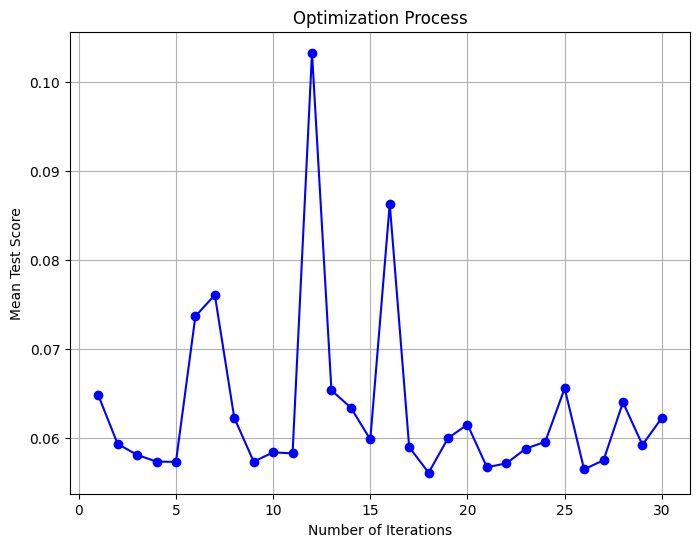

In [20]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

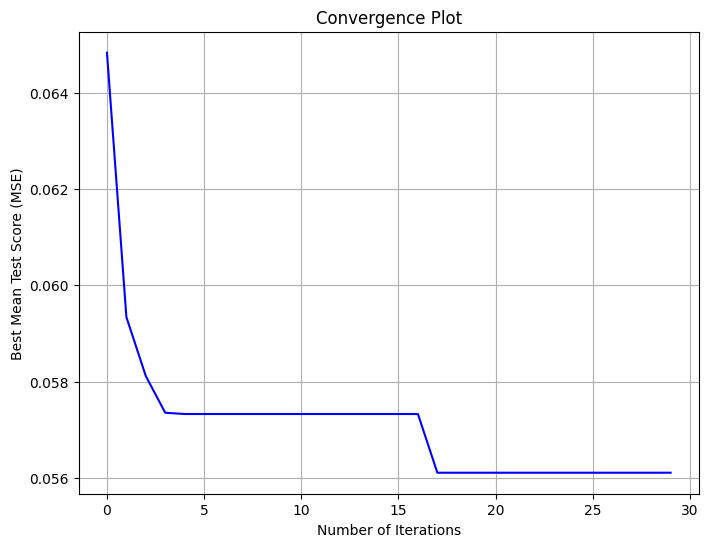

In [21]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

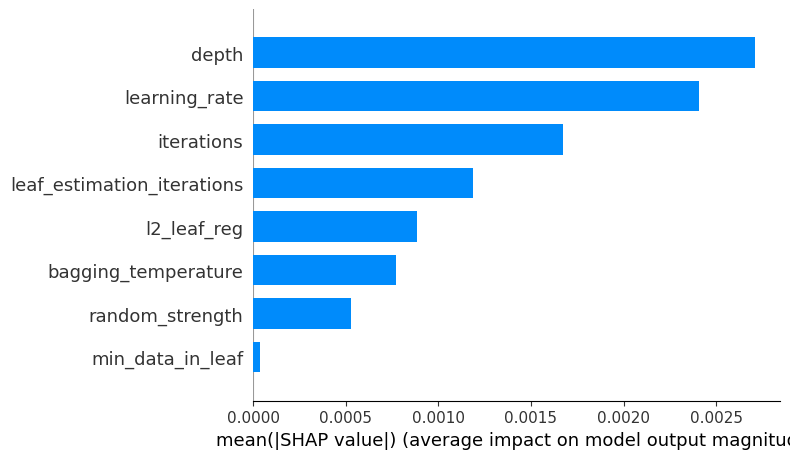

In [22]:
results = opt.cv_results_
params = results['params']
# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

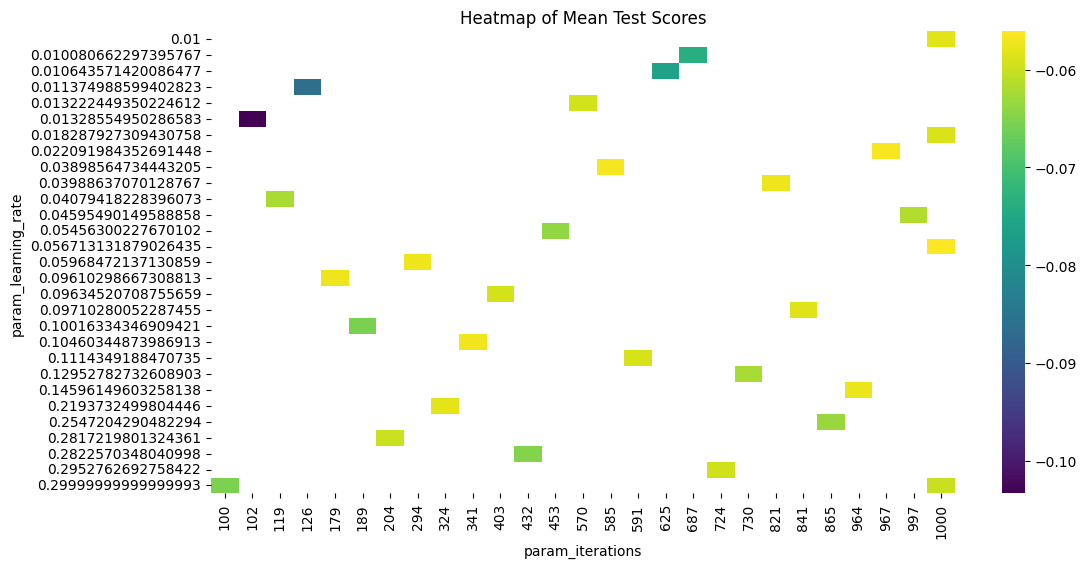

In [23]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [25]:
best_model = opt.best_estimator_
preds = best_model.predict(X_test[selected])
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(by='Error', ascending=False).head(30)
print(top_30_errors)

     Ticker        Date  Future_Price_pct_diff_1  Predicted     Error
6407   SMCI  2024-06-30                 2.553191   0.385818  2.167373
5834   PLTR  2025-03-31                 1.033064   0.553227  0.479837
7362    VST  2024-06-30                 0.814395   0.535235  0.279160
7605    WSM  2025-02-02                -0.129893   0.147497  0.277390
2034   DELL  2024-08-02                 0.454895   0.179548  0.275347
6883    TPL  2025-03-31                 0.251291  -0.021464  0.272755
3007   FSLR  2024-09-30                 0.335664   0.076244  0.259420
7091    UAL  2025-03-31                 0.701717   0.449086  0.252631
6979   TSLA  2025-03-31                 0.543554   0.298758  0.244796
7152   ULTA  2024-05-04                 0.330271   0.087863  0.242408
6807    TGT  2024-05-04                 0.370857   0.144063  0.226794
6409   SMCI  2024-12-31                -0.491792  -0.266809  0.224984
2272    DVA  2024-03-31                 0.108220   0.330367  0.222147
5369   NVDA  2024-07

<Axes: >

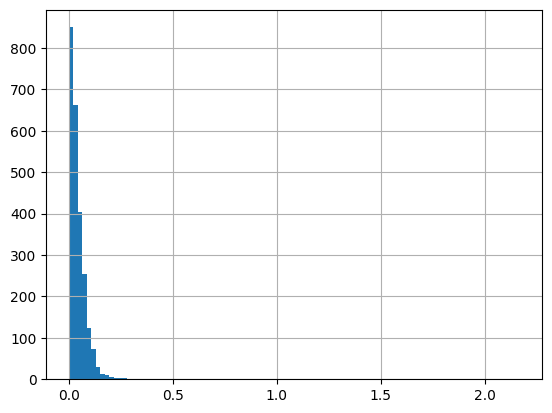

In [26]:
error_df['Error'].hist(bins=100)

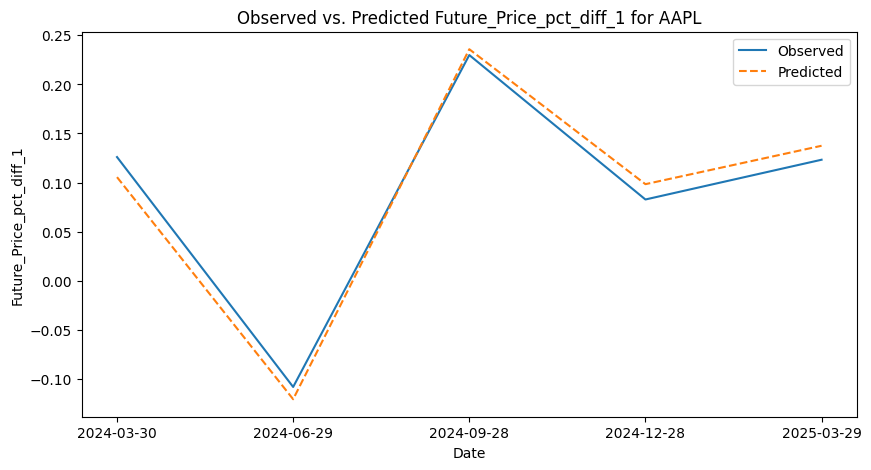

Mean error: 0.01374494356471458


In [27]:
ticker = 'AAPL'

ticker_example = test_df[test_df['Ticker'] == ticker]
plt.figure(figsize=(10, 5))
plt.plot(ticker_example['Date'], ticker_example[target], label='Observed')
plt.plot(ticker_example['Date'], best_model.predict(Pool(ticker_example[features], cat_features=cat_features)),
         label='Predicted', linestyle='--')
plt.title(f'Observed vs. Predicted {target} for {ticker}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

print(
    f'Mean error: {error_df.loc[error_df["Ticker"]==ticker, "Error"].mean()}')